<a href="https://colab.research.google.com/github/ibenatar-96/Bayesian-Modeling-RL/blob/main/bayesian_modeling_pomdp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd /content/
!pip install numpyro
!pip install funsor
!git clone https://github.com/ibenatar-96/Bayesian-Modelling-RL
%cd /content/Bayesian-Modelling-RL
!git pull
%cd /content/

/content
fatal: destination path 'Bayesian-Modelling-RL' already exists and is not an empty directory.
/content/Bayesian-Modelling-RL
Already up to date.
/content


In [ ]:
import numpy as np
import numpyro
import numpyro.distributions as dist
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import sys
import os
import time
import copy
import random
sys.path.append('/content/Bayesian-Modelling-RL')
import actions
import environment
import utils
import solver
import actions

numpyro.set_host_device_count(4)

# Intro to POMDPs

A Partially Observable Markov Decision Process (POMDP) is defined as a tuple $(S, A, T, R, Ω, O, γ)$, where:
- $S$: Finite set of states representing the environment.
- $A$: Finite set of actions available to the agent.
- $T$: State transition function $T: S \times A \mapsto S$, determining the transition probabilities between states based on actions.
- $R$: Reward function $R: S \times A \mapsto \mathbb{R}$, providing immediate rewards for actions in specific states.
- $O$: Finite set of observations that the agent can perceive.
- $Ω$: A set of conditional observation probabilities
- $γ$: The discount factor is a number ∈ $[0,1]$

# Tic-Tac-Toe Domain

Our Tic-Tac-Toe domain is composed of:

- $S$: All the possible configurations of a tic tac toe board - For each cell there could be 'X', 'O', or None (Empty).
Total of $3^{9}$ states. (Some are redundant because we will reach termination state before, for example a board with all 'X's will never be visited because we will reach terminate state after there is a row / column / diagonal with all 'X's.
- $A$: For each state, the set of possible actions are marking 'O' (functions denoted as 'ai_mark') in the empty cells of that state. For example, if our state is:
\begin{bmatrix}
    X & O & None \\
    None & O & X \\
    O & X & None
\end{bmatrix}
\
Then our actions would be:
$\{('ai\_mark', 3), ('ai\_mark', 4),('ai\_mark', 9)\}$

* $T$: Our set of conditional transition proabilities between states is initially$\mbox{*}$ defined as:
\
\begin{align}
        \text{T(s'|s,a)} = \left\{
        \begin{array}{cl}
        1.0 & a = 1,2,3,4\;and\;s \; is \; legal  \\
        0.3 & a = 5 \;and\;s \; is \; legal\\
        1.0 & a = 6,7,8,9 \;and\;s \; is \; legal\\
        \end{array}
        \right.
\end{align}
$state\;s$ is legal meaning that our board representation of $state\;s$ does not have a mark in cell $a$, alternative definition is that $s[a]=None$.
\
$\mbox{*}$ The correct / real transition of how our agent interacts with the environment is what we are trying to model in this notebook.

* $R$: Our reward function is:
\begin{align}
        \text{R(r|s,a)} = \left\{
        \begin{array}{cl}
        -1 & for\;every\;action\;taken  \\
        10 & action\;a\;from\;s\;leads\;to\;terminal\;state\;and\;agent\;won\\
        -10 & action\;a\;from\;s\;leads\;to\;terminal\;state\;and\;agent\;lost\\
                0 & action\;a\;from\;s\;leads\;to\;terminal\;state\;and\;draw
        \end{array}
        \right.
\end{align}

* $Ω$: Our observation space is similar to $S$, because our partially observability is regarding what state we are in, and not partial information in the state.

* $O$: Our conditional observation probabilities function is:
\begin{align}
        \text{O(o|s',a,s)} = \left\{
        \begin{array}{cl}
        s & prob(0.3)\;and\;a=1,2 \\
        s' & prob(0.7)\;and\;a=1,2 \\
        \\
        s & prob(0.2)\;and\;a=3 \\
        s' & prob(0.8)\;and\;a=3 \\
        \\
        s & prob(0.05)\;and\;a=4 \\
        s' & prob(0.95)\;and\;a=4 \\
        \\
        ...\\
        See\;Noise\;Probabilities\;function.
        \end{array}
        \right.
\end{align}

Noise Probabilities defines our probabilities to recieve a noisy observation.
\
Meaning, we will observe the same state $s$ when $Bernoulli(Noise\_Probabilities(a))$ is true, else we recieve $observation \;s'$

* $γ$: Our gamma (discount factor) is set to be 0.95.

# Bayesian Modelling POMDPs Transition models

Our scientific problem is in the realm of planning and decision making.
\
Our assumptions our that we do not know how our model interacts with the environment (transition model with probabilities), and that an execution of a trajectory (the path of the agent through the state space up until the horizon) is costly.

Because of these assumptions, we will define a "fictive" environment - with our belief of what are the probabilities for the agent to succeed; and basically train our Agent using model-based Reinforcment Learning on that environment.

We are looking into learning the Transition Model parameters, using few observations, and improving the accuracy of our Agent through improving our belief of the transition model.

For this we will use Bayesian Modelling.

# Tic Tac Toe POMDP Domain

To show improvement in our Agent accuracy, we will define a Tic Tac Toe with probabilities domain.

We are training our AI Agent to play Tic Tac Toe, in a domain where there is a probability to successfully mark 'O' in a given cell.

The (Real) parameters (that are unknown to us) for successfully marking 'O' in a given cell are:

\begin{align}
        \text{Transition_Proability}(x) = \left\{
        \begin{array}{cl}
        1.0 & x = 1,2,3,4 \\
        0.3 & x = 5 \\
        1.0 & x = 6,7,8,9 \\
        \end{array}
        \right.
    \end{align}

Where 'x' is the cell our AI Agent is trying to mark.

Our Agent is learning using Q-Learning Reinforcment Learning algorithm, given an estimate* for his Transition Probability model.

We want to improve our estimate each iteration, and by thus improve our accuracy (how many times our AI Agent wins).

A full iteration is defined by:
    
    1. Train our AI Agent and compute an optimal policy using Q-Learning, against an optimal Tic Tac Toe opponent,
    with our model of the env. which has an estimate for each transition (cell marking) probability.

    2. Evaluate our optimal policy from clause 1 through playing against a random Tic Tac Toe opponent (uniform probability to mark 'X' in each cell).
    In this step we do not collect observations, this is done for evaluation and research only.

    3. Play 15 games and collect additional observations.

    4. Run inference on our model and observations, and improve our estimate of the transition model parameters.

\

In our Tic Tac Toe with probability domain, we are assuming that playing a game of Tic Tac Toe is expensive, so our training is done with our modelling of the environment. And in most cases we will not know our exact transition model parameters, so we are looking into Bayesian Modelling our POMDP.

\

estimate* - Our initial estimate on how the Transition model behaves is:

\begin{align}
        \text{Initial_Estimate}(x) = \left\{
        \begin{array}{cl}
        1.0 & x = 1,2,3,4 \\
        0.8 & x = 5 \\
        1.0 & x = 6,7,8,9 \\
        \end{array}
        \right.
    \end{align}

# Partial Observations

What is the probability that we will see noisy observation at cell 'x'?

Noise in our domain is observing Empty (None) instead of 'O', and vice versa.

\begin{align}
        \text{Noise_Probabilities}(x) = \left\{
        \begin{array}{cl}
        0.3 & x = 1,2 \\
        0.2 & x = 3 \\
        0.05 & x = 4 \\
        0.4 & x = 5,6 \\
        ... \\
        0.1 & x = 9
        \end{array}
        \right.
    \end{align}

\
$ Noise \;at \; cell \; 'i' = Bernoulli(Noise\_Probabilities(i)) $
\
\
$ grid[i]\; = $

$ \quad if\;(grid[i] = 'O' \; and \; not \; Noise(i)) \; OR \; (grid[i]=None \; and \; Noise(i)) \; then \; 'O' $
\
\
$ \quad else\;if\;(grid[i]='X')\; then \; 'X'$
\
\
$ \quad else\;Empty \; (None)$

\
In simple terms, if grid[i] is 'O' and there is no Noise, OR grid[i] is Empty (None) and there is Noise,
Then the belief is that grid[i] contains 'O'.

If grid[i] is 'X' OR grid[i] is Empty (None), then there is no partial observability, meaning the cell is accordingly.

If grid[i] is 'O' and there is Noise, then the belief is that grid[i] is Empty (None).

# Init Global Parameters

My assumption is that we have one Agent function - $'ai\_mark'$, that can take in 9 different parameters: 1-9.

So for example ('ai_mark', 3) will denote the action marking 'O' in cell 3.

$model\_beta\_parameters = \{(0,1):\; \{\alpha:\;1,\;\beta:1\},\;(0,2):\;\{\alpha:\;1,\;\beta:1\},\;...,\; (0,9):\; \{\alpha:\;1,\;\beta:1\}\} $
Based on bayesian_modelling_mdp.ipynb, each tuple (function, action) is initialized with a prior distribution of $Beta\sim(1, 1)$.

These are the latent variables we are trying to learn.

\

We will define a $fn\_numeric\_mapping$ dictionary that holds a mapping between function and a numeric value, this is used to infer using NumPyro (requires numbers and not string).

Again, because we are assuming only one Agent function exists ('ai_mark') we will have only one mapping - 'ai_mark': 0.

In [ ]:
noise_probabilities = [0.3, 0.3, 0.2, 0.05, 0.4, 0.15, 0.0, 0.0, 0.1]
# noise_probabilities = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
model_beta_parameters = {(0,1): {'alpha': 1, 'beta': 1}, (0,2): {'alpha': 1, 'beta': 1}, (0,3): {'alpha': 1, 'beta': 1}, (0,4): {'alpha': 1, 'beta': 1},
                          (0,5): {'alpha': 1, 'beta': 1}, (0,6): {'alpha': 1, 'beta': 1}, (0,7): {'alpha': 1, 'beta': 1}, (0,8): {'alpha': 1, 'beta': 1},
                          (0,9): {'alpha': 1, 'beta': 1}}
fn_numeric_mapping = {'ai_mark': 0}

# Creating Synthetic Observation List

Based on the Psuedo code written in the 'Partial Observations' text cell, we will create 'synthetic' observations.

In [ ]:
def create_synthetic_obs(prob_vector):
    actions = [(0,1),(0,2),(0,3),(0,4),(0,5),(0,6),(0,7),(0,8),(0,9)]
    obs_list = []
    for _ in range(15):
        for action in actions:
            state = [random.choice([1,0,-1]) if cell != (action[1]-1) else 0 for cell in range(9)]
            action = action
            p_success = utils.REAL_MODEL_PARAMETERS[('ai_mark', action[1])]
            p_noise = prob_vector[action[1]-1]
            success = np.random.choice([0, 1], size=1, p=[1 - p_success, p_success])
            noise = np.random.choice([0, 1], size=1, p=[1 - p_noise, p_noise])
            # success = numpyro.sample('success', dist.Bernoulli(probs=success_prob), rng_key=jax.random.PRNGKey(int(time.time() * 1E6))).item()
            # noise = numpyro.sample('noise', dist.Bernoulli(probs=noise_prob), rng_key=jax.random.PRNGKey(int(time.time() * 1E6))).item()
            next_state = copy.deepcopy(state)
            if (success and not noise) or (not success and noise):
                next_state[action[1]-1] = 1
            obs_list.append((state, action, next_state))
    return obs_list

In [ ]:
obs_list = create_synthetic_obs(noise_probabilities)
for i, obs in enumerate(obs_list):
    print(f"obs[{i}]: {obs}")

obs[0]: ([0, 0, -1, -1, 1, 0, 1, 0, 0], (0, 1), [1, 0, -1, -1, 1, 0, 1, 0, 0])
obs[1]: ([1, 0, -1, 1, 1, 0, -1, 1, 0], (0, 2), [1, 1, -1, 1, 1, 0, -1, 1, 0])
obs[2]: ([0, 0, 0, -1, 0, 0, 1, -1, 0], (0, 3), [0, 0, 1, -1, 0, 0, 1, -1, 0])
obs[3]: ([1, -1, -1, 0, -1, -1, -1, -1, -1], (0, 4), [1, -1, -1, 1, -1, -1, -1, -1, -1])
obs[4]: ([0, -1, 0, 1, 0, 1, -1, -1, -1], (0, 5), [0, -1, 0, 1, 0, 1, -1, -1, -1])
obs[5]: ([0, 1, -1, 0, 0, 0, 0, 0, 1], (0, 6), [0, 1, -1, 0, 0, 1, 0, 0, 1])
obs[6]: ([-1, 1, 1, 1, -1, -1, 0, -1, 0], (0, 7), [-1, 1, 1, 1, -1, -1, 1, -1, 0])
obs[7]: ([1, 1, 0, 0, 0, 1, 0, 0, 1], (0, 8), [1, 1, 0, 0, 0, 1, 0, 1, 1])
obs[8]: ([1, 1, 1, 0, 1, 0, 0, 0, 0], (0, 9), [1, 1, 1, 0, 1, 0, 0, 0, 1])
obs[9]: ([0, 0, 0, 1, 0, 1, 1, -1, 1], (0, 1), [1, 0, 0, 1, 0, 1, 1, -1, 1])
obs[10]: ([1, 0, 0, 0, -1, -1, 1, 0, 1], (0, 2), [1, 0, 0, 0, -1, -1, 1, 0, 1])
obs[11]: ([1, 1, 0, -1, 1, -1, 0, 0, 0], (0, 3), [1, 1, 1, -1, 1, -1, 0, 0, 0])
obs[12]: ([-1, 0, 1, 0, -1, -1, -1, 1, 0], (

# AI Model

Defining our AI model,

We are trying to infer our Transition Model - which is defined by our 9 tuples:

('ai_mark', 1),
('ai_mark', 2),
...
('ai_mark', 9).

Our prior on these actions is:

$p('ai\_mark', \; cell) \sim Beta(1,1)$

For the ability to iterate and save our posterior Beta distributions, we will get and save our $alpha, \; beta$ parameters for our $Beta$ distributions in the global mapping dictionary - $model\_beta\_parameters$.
\
Our observation ("o" parameter) is drawn from the Bernoulli distribution, with probability: $(Action\;success\; probability) \times [1 \;-\; (Noise\; probability)] \;+\;[1 \;-\; (Action\;success\; probability)] \times (Noise\; probability) $

Our noise is modelled using the Noise_Probabilities that was defined in the Global Parameters cell.

In [ ]:
def ai_model(obs=None):
    # p ~ Beta(alpha, beta)
    p = {}
    noise = {}
    for key in model_beta_parameters.keys():
        alpha = model_beta_parameters[key]['alpha']
        beta = model_beta_parameters[key]['beta']
        p[key] = numpyro.sample(f"p{str(key)}", dist.Beta(alpha, beta))
        # p = {(0,1): sample_1, (0,2): sample_2, ..., (0,9): sample_9}
        noise[key] = numpyro.param(f"noise{str(key)}", noise_probabilities[key[1]-1])

    if obs is not None:
        p_actions = jax.numpy.array([p[action] for _, action, _ in obs]) # [sample_4, sample_5, sample_2, sample_7, sample_4, sample_5, ...]
        p_noise = jax.numpy.array([noise[action] for _, action, _ in obs], dtype='float32') # [noise_4, noise_5, noise_2, ...]
        success = jax.numpy.array([1 if state != next_state else 0 for state, _, next_state in obs]) # [1, 0, 1, 1, ...]
        with numpyro.plate("obs", size=len(obs)):
            # numpyro.sample("o", dist.Bernoulli((p_actions * (1-p_noise)) + ((1-p_actions) * p_noise)), obs=success)
            action_outcome = numpyro.sample("action_outcome", dist.Bernoulli(p_actions))
            selected_noise = jax.numpy.where(action_outcome, 1-p_noise, p_noise)
            numpyro.sample("o", dist.Bernoulli(selected_noise), obs=success)


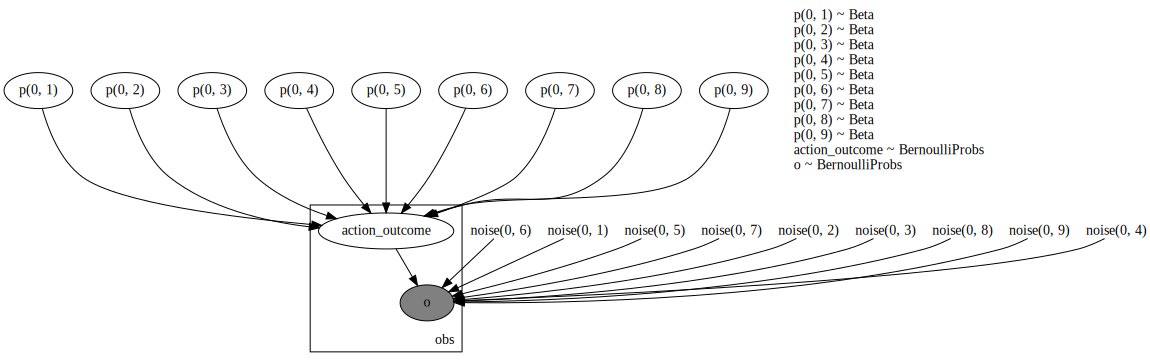

In [ ]:
numpyro.render_model(ai_model, model_args=(obs_list,), render_distributions=True, render_params=True,)

# Evaluating Prior Predictive from the Prior Distribution

Running our AI Model (without observations) to evaluate prior predictive from out prior distribution.

In our first iteration we are expecting to see around 0.5 probability for success and failure, because our prior distribution is $Beta(1,1)$ which is basically the same as $Uniform(0,1)$.

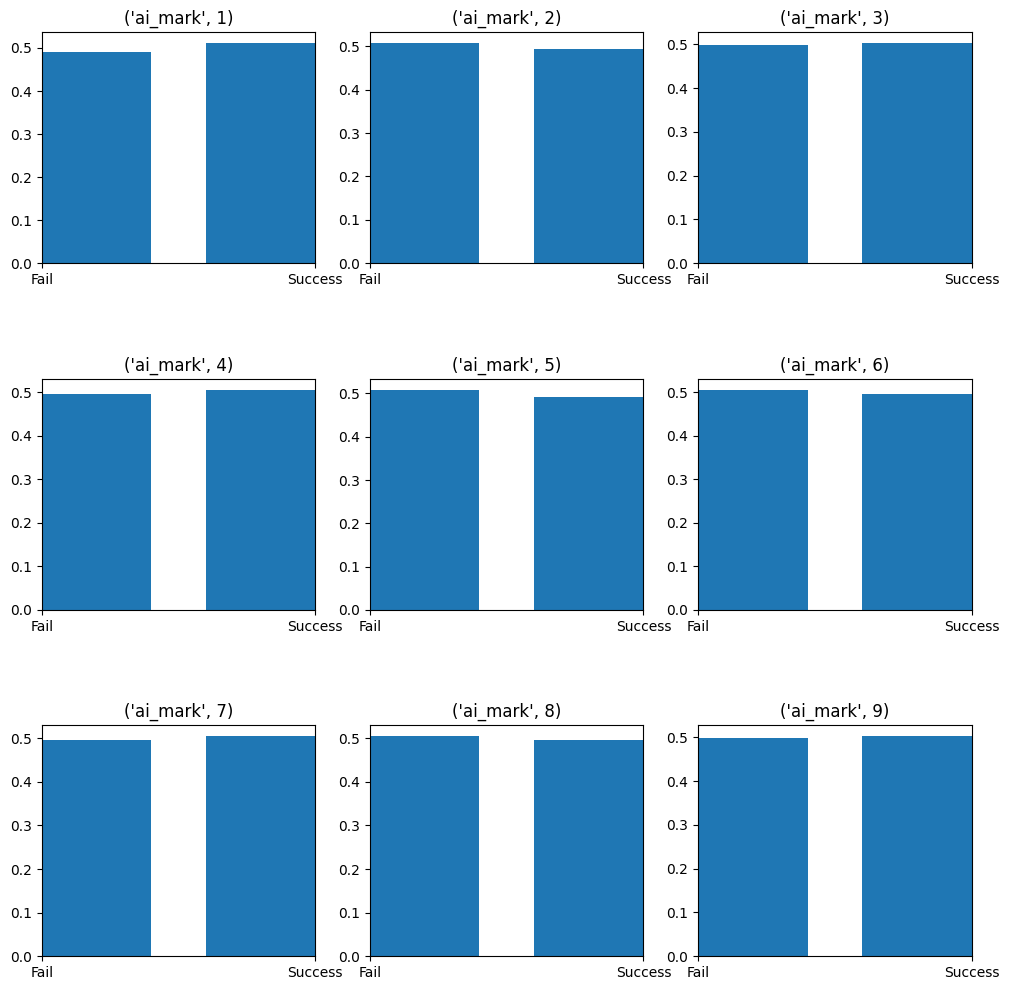

In [ ]:
prior_predi = numpyro.infer.Predictive(ai_model, num_samples=10000)
prior_samples = prior_predi(jax.random.PRNGKey(int(time.time() * 1E6)))

num_mapping = len(model_beta_parameters.keys())
num_rows, num_cols = utils.largest_divisors(num_mapping)
assert num_rows * num_cols == num_mapping
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))
plt.subplots_adjust(hspace=0.5)
plt.title("prior predictive")
for i in range(num_rows):
    for j in range(num_cols):
        fn_num, action_param = list(model_beta_parameters.keys())[i*3 + j]
        o_key = f"p{str((fn_num, action_param))}" # Need to revert this to o{str(key)}
        x_titles = ["Fail", "Success"]
        fn_name = next((k for k, v in fn_numeric_mapping.items() if v == fn_num), None)
        title = (fn_name, action_param)
        axs[i, j].set_title(title)
        axs[i, j].set_xlim(0, 1)
        success_counts = np.sum(prior_samples[o_key] > 0.5, axis=0)
        fail_counts = np.sum(prior_samples[o_key] < 0.5, axis=0)
        normalized_vector = [np.mean(fail_counts), np.mean(success_counts)]
        sum_normalized = np.sum(normalized_vector)
        normalized_vector /= sum_normalized
        axs[i, j].bar(x_titles, normalized_vector)
plt.show()

# Running Inference using MCMC.

In [ ]:
nuts_kernel = numpyro.infer.NUTS(ai_model)
mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    num_warmup=500,
    num_chains=4,
    num_samples=5000)
mcmc.run(jax.random.PRNGKey(int(time.time() * 1E6)), obs=obs_list)
mcmc.print_summary()

/usr/local/lib/python3.10/dist-packages/jax/_src/linear_util.py:188: FutureWarning: Some algorithms will automatically enumerate the discrete latent site action_outcome of your model. In the future, enumerated sites need to be marked with `infer={'enumerate': 'parallel'}`.
  ans = self.f(*args, **dict(self.params, **kwargs))


  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   p(0, 1)      0.78      0.18      0.82      0.53      1.00  27465.23      1.00
   p(0, 2)      0.78      0.18      0.82      0.52      1.00  24067.01      1.00
   p(0, 3)      0.90      0.09      0.93      0.78      1.00  27432.58      1.00
   p(0, 4)      0.94      0.06      0.95      0.86      1.00  25115.02      1.00
   p(0, 5)      0.30      0.24      0.25      0.00      0.66  26850.65      1.00
   p(0, 6)      0.88      0.10      0.90      0.73      1.00  27394.12      1.00
   p(0, 7)      0.94      0.06      0.96      0.86      1.00  27943.41      1.00
   p(0, 8)      0.94      0.05      0.96      0.87      1.00  25454.56      1.00
   p(0, 9)      0.87      0.10      0.89      0.73      1.00  29519.59      1.00

Number of divergences: 0


# Posterior Predictive

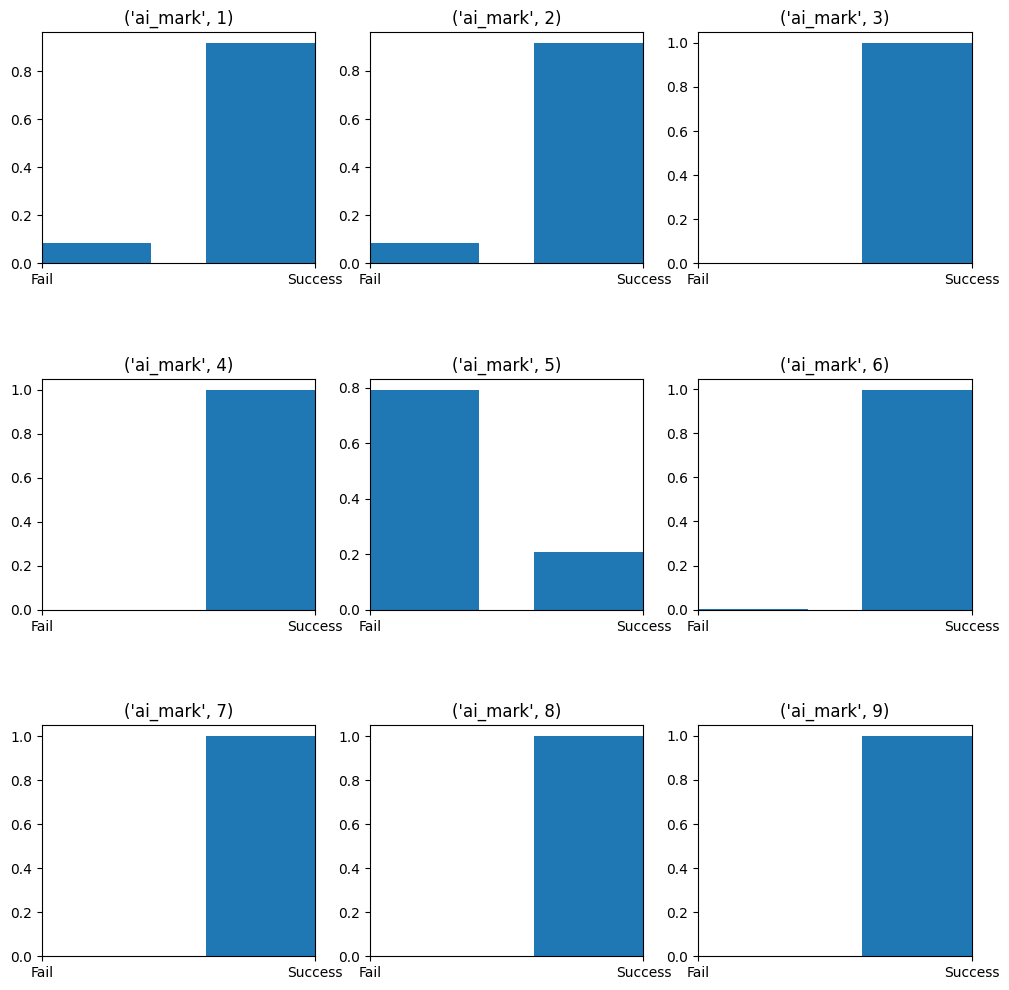

In [ ]:
num_mapping = len(model_beta_parameters.keys())
num_rows, num_cols = utils.largest_divisors(num_mapping)
assert num_rows * num_cols == num_mapping
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))
plt.subplots_adjust(hspace=0.5)
plt.title("posterior")
for i in range(num_rows):
    for j in range(num_cols):
        fn_num, action_param = list(model_beta_parameters.keys())[i*3 + j]
        p_key = f"p{str((fn_num, action_param))}"
        x_titles = ["Fail", "Success"]
        fn_name = next((k for k, v in fn_numeric_mapping.items() if v == fn_num), None)
        title = (fn_name, action_param)
        axs[i, j].set_title(title)
        axs[i, j].set_xlim(0, 1)
        success_counts = np.sum(mcmc.get_samples()[p_key] > 0.5, axis=0)
        fail_counts = np.sum(mcmc.get_samples()[p_key] < 0.5, axis=0)
        normalized_vector = [np.mean(fail_counts), np.mean(success_counts)]
        sum_normalized = np.sum(normalized_vector)
        normalized_vector /= sum_normalized
        axs[i, j].bar(x_titles, normalized_vector)
plt.show()

# Summarizing the Posterior

Summarizes Posterior, displays attributes such as mean, standard deviation, quantiles.

stat	p(0, 1)
-------------
mean	0.777
stddev	0.176
  0%	0.003
  2%	0.344
 25%	0.678
 50%	0.816
 75%	0.917
 98%	0.992
100%	1.000


stat	p(0, 2)
-------------
mean	0.776
stddev	0.176
  0%	0.005
  2%	0.343
 25%	0.674
 50%	0.816
 75%	0.915
 98%	0.992
100%	1.000


stat	p(0, 3)
-------------
mean	0.902
stddev	0.089
  0%	0.292
  2%	0.668
 25%	0.860
 50%	0.928
 75%	0.969
 98%	0.997
100%	1.000


stat	p(0, 4)
-------------
mean	0.937
stddev	0.059
  0%	0.515
  2%	0.784
 25%	0.912
 50%	0.955
 75%	0.981
 98%	0.998
100%	1.000


stat	p(0, 5)
-------------
mean	0.304
stddev	0.238
  0%	0.000
  2%	0.009
 25%	0.108
 50%	0.250
 75%	0.450
 98%	0.872
100%	1.000


stat	p(0, 6)
-------------
mean	0.875
stddev	0.101
  0%	0.255
  2%	0.622
 25%	0.819
 50%	0.900
 75%	0.955
 98%	0.996
100%	1.000


stat	p(0, 7)
-------------
mean	0.941
stddev	0.057
  0%	0.484
  2%	0.790
 25%	0.918
 50%	0.957
 75%	0.982
 98%	0.998
100%	1.000


stat	p(0, 8)
-------------
mean	0.942
stddev	0.054
  0%	0.503
  2%	0.799
 25%	0.918
 50%	0

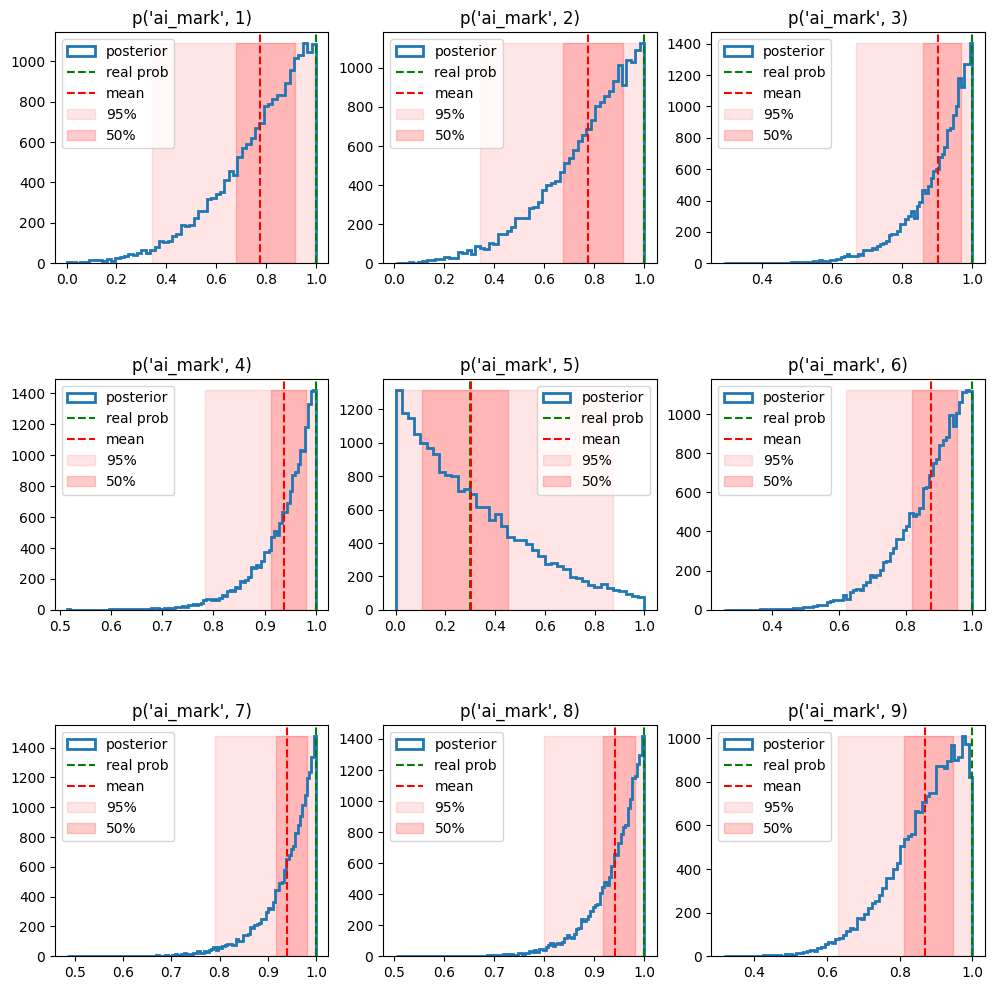

In [ ]:
distribution_stats = {}
num_mapping = len(model_beta_parameters.keys())
num_rows, num_cols = utils.largest_divisors(num_mapping)
assert num_rows * num_cols == num_mapping
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))
plt.subplots_adjust(hspace=0.5)
# obs_list = list(obs.items())
for i in range(num_rows):
    for j in range(num_cols):
        fn_num, action_param = list(model_beta_parameters.keys())[i*3 + j]
        fn_name = next((k for k, v in fn_numeric_mapping.items() if v == fn_num), None)
        title = (fn_name, action_param)
        key = (fn_num, action_param)
        real_param = utils.REAL_MODEL_PARAMETERS[(fn_name, action_param)]
        p_key = f"p{str(key)}"
        p = mcmc.get_samples()[p_key]
        p_mean = p.mean()
        p_stddev = p.std()
        distribution_stats[key] = {'mean': p_mean, 'stddev': p_stddev}
        quantiles = [0, 0.025, 0.25, 0.5, 0.75, 0.975, 1]
        pq = np.quantile(p, quantiles)
        print(f"stat\t{p_key}\n-------------")
        print(f"mean\t{p_mean:.3f}")
        print(f"stddev\t{p_stddev:.3f}")
        for q in range(len(quantiles)):
            print(f"{quantiles[q] * 100:3.0f}%\t{pq[q]:.3f}")
        print("\n")
        height, _, _ = axs[i, j].hist(p, histtype="step", lw=2, bins="auto", label="posterior")
        axs[i, j].set_title(f"p{title}")
        axs[i, j].axvline(real_param, ls="dashed", color="green", label="real prob")
        axs[i, j].axvline(p_mean, ls="dashed", color="red", label="mean")
        axs[i, j].fill_betweenx([0, height.max()], pq[1], pq[-2],
                                color="red", alpha=0.1, label=f"{(quantiles[-2] - quantiles[1]) * 100:.0f}%")
        axs[i, j].fill_betweenx([0, height.max()], pq[2], pq[-3],
                                color="red", alpha=0.2, label=f"{(quantiles[-3] - quantiles[2]) * 100:.0f}%")
        axs[i, j].legend()
plt.show()